# Setup

## Install Python dependencies

In [1]:
!python3 -m pip install numba umap-learn leidenalg scikit-learn-extra

/etc/host.conf: line 4: bad command `nospoof on'
     |████████████████████████████████| 3.3 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 8.0 MB/s  eta 0:00:01
  Using cached leidenalg-0.8.9-cp39-cp39-manylinux2010_x86_64.whl (1.4 MB)
     |████████████████████████████████| 1.9 MB 15.5 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 900 kB/s  eta 0:00:01
     |████████████████████████████████| 26.4 MB 6.6 MB/s eta 0:00:011
     |████████████████████████████████| 42.1 MB 4.2 MB/s eta 0:00:01     |██████████████████████████      | 34.3 MB 3.0 MB/s eta 0:00:03
     |████████████████████████████████| 1.1 MB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 3.1 MB/s eta 0:00:01
  Using cached igraph-0.9.9-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached texttable-1.6.4-py2.py3-none-any.whl (10 kB)
     |█████████████████████████████

## Imports

In [31]:
import os
import re
import umap
import umap.plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.utils.data as data_utils
from torch import nn
import torch.nn.functional as F

## Check GPU status

In [32]:
torch.cuda.is_available()

True

## Paths

In [33]:
DATA_DIR = '/data/VariantAnalysis/'
REPRESENTATIONS_DIR = os.path.join(DATA_DIR, 'esm1b_preprs')
VAE_MODEL_DIR = os.path.join(DATA_DIR, 'vae_model')

## Other params

In [68]:
GENE_NAME = 'P53'

ALL_AAS = list('ACDEFGHIKLMNPQRSTVWY')

In [69]:
len(ALL_AAS)

20

# Parse input mutations

In [70]:
os.path.join(REPRESENTATIONS_DIR, GENE_NAME, '%s_logits.csv' % GENE_NAME)

'/data/VariantAnalysis/esm1b_preprs/P53/P53_logits.csv'

In [71]:
wt_logits = pd.read_csv(os.path.join(REPRESENTATIONS_DIR, GENE_NAME, '%s_logits.csv' % GENE_NAME), index_col = 0)\
        .rename(columns = lambda col_name : col_name.split('.')[0])
wt_ref_logits = np.array([pos_wt_logits[pos_ref_aa] for pos_ref_aa, pos_wt_logits in wt_logits.iteritems()])
LLR = (wt_logits - wt_ref_logits.reshape(1, -1)).loc[ALL_AAS]

mutation_names = np.load(os.path.join(REPRESENTATIONS_DIR, GENE_NAME, 'mutation_names.npy'))
mutation_esm1b_reprs = np.load(os.path.join(REPRESENTATIONS_DIR, GENE_NAME, 'mutation_reprs.npy'))

mutations = pd.DataFrame(index = mutation_names)

In [72]:
mutation_esm1b_reprs.shape

(11060, 1280)

In [73]:
LLR.shape

(20, 393)

In [74]:
mutations.shape

(11060, 0)

In [75]:
mutations['ref_index'] = [x for x in range(mutations.shape[0])]

In [76]:
mutations = mutations.loc[[gene for gene in mutations.index.tolist() if gene.split(':')[0] == GENE_NAME]]

In [77]:
mutations['name'] = [mutation_name for gene_name, mutation_name in mutations.index.str.split(':')]
mutations['pos'] = mutations['name'].apply(lambda mutation_name: np.nan if mutation_name == 'WT' else \
        int(mutation_name[1:-1]))

In [78]:
mutations.head()

,ref_index,name,pos
P53:WT,0,WT,NaN
P53:M1V,1,M1V,1.0
P53:M1Y,2,M1Y,1.0
P53:M1P,3,M1P,1.0
P53:M1D,4,M1D,1.0


In [79]:
mutations['alt_aa'] = mutations['name'].apply(lambda mutation_name: np.nan \
                                              if mutation_name == 'WT' else \
                                              mutation_name[-1])

In [80]:
mutations.head()

,ref_index,name,pos,alt_aa
P53:WT,0,WT,NaN,NaN
P53:M1V,1,M1V,1.0,V
P53:M1Y,2,M1Y,1.0,Y
P53:M1P,3,M1P,1.0,P
P53:M1D,4,M1D,1.0,D


In [81]:
mutations['zeroshot_raw'] = mutations.apply(lambda mutation: 0 if mutation['name'] == 'WT' else \
        LLR.loc[mutation['alt_aa']].iloc[int(mutation['pos']) - 1], axis = 1)

In [82]:
mutations.head()

,ref_index,name,pos,alt_aa,zeroshot_raw
P53:WT,0,WT,NaN,NaN,0.000000
P53:M1V,1,M1V,1.0,V,-6.698508
P53:M1Y,2,M1Y,1.0,Y,-8.338982
P53:M1P,3,M1P,1.0,P,-5.708129
P53:M1D,4,M1D,1.0,D,-7.114252


In [83]:
zeroshot = np.clip(mutations['zeroshot_raw'], None, 0)
zeroshot -= zeroshot.min()
zeroshot /= zeroshot.max()
mutations['zeroshot'] = zeroshot

display(mutations)

,ref_index,name,pos,alt_aa,zeroshot_raw,zeroshot
P53:WT,0,WT,NaN,NaN,0.000000,1.000000
P53:M1V,1,M1V,1.0,V,-6.698508,0.684250
P53:M1Y,2,M1Y,1.0,Y,-8.338982,0.606923
P53:M1P,3,M1P,1.0,P,-5.708129,0.730934
P53:M1D,4,M1D,1.0,D,-7.114252,0.664653
...,...,...,...,...,...,...
P53:D393Q,7463,D393Q,393.0,Q,-5.540351,0.738843
P53:D393F,7464,D393F,393.0,F,-6.265056,0.704682
P53:D393I,7465,D393I,393.0,I,-7.186170,0.661263
P53:D393C,7466,D393C,393.0,C,-5.644102,0.733952


Text(0, 0.5, '# mutations')

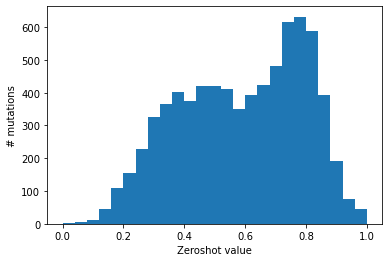

In [84]:
fig, ax = plt.subplots()
ax.hist(mutations['zeroshot'], bins = 25)
ax.set_xlabel('Zeroshot value')
ax.set_ylabel('# mutations')

In [22]:
# mutations['ref_index'].tolist()

In [85]:
X = StandardScaler().fit_transform(mutation_esm1b_reprs[mutations['ref_index'].tolist(),:])

# Train a low-dimensional auto-encoder

## Params

In [86]:
PARAMS = {
    'input_dim': 1280,
    'intermediate_dim': 128,
    'latent_dim': 15,
    'kl_weight': 0.1,
    'pred_weight': 50,
    'batch_size': 512,
    'train_size': 0.8,
    'n_epochs': 400,
    'lr': 1e-03,
}

## Define and train the model

In [88]:
class VAE(nn.Module):
    
    def __init__(self, input_dim, intermediate_dim, latent_dim):
        
        nn.Module.__init__(self)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim

        # Encoder
        self.input_enc = nn.Linear(in_features = self.input_dim, out_features = self.intermediate_dim)
        self.batch_norm_enc = nn.BatchNorm1d(self.intermediate_dim)
        self.drop_enc = nn.Dropout(p = 0.05)
        self.mu_enc = nn.Linear(in_features = self.intermediate_dim, out_features = self.latent_dim)
        self.logvar_enc = nn.Linear(in_features = self.intermediate_dim, out_features = self.latent_dim)
 
        # Decoder 
        self.latent_dec = nn.Linear(in_features = self.latent_dim, out_features = self.intermediate_dim)
        self.batch_norm_dec = nn.BatchNorm1d(self.intermediate_dim)
        self.drop_dec = nn.Dropout(p = 0.05)
        self.out_dec = nn.Linear(in_features = self.intermediate_dim, out_features = self.input_dim)
        self.y_dec = nn.Linear(in_features = self.latent_dim, out_features = 1, bias = False)
                
    def encode(self, x):
        x = self.drop_enc(F.relu(self.batch_norm_enc(self.input_enc(x))))
        x_mu = self.mu_enc(x)
        x_logvar = self.logvar_enc(x)
        return x_mu, x_logvar
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        r = torch.randn_like(std)
        z = mu + r * std
        return z
    
    def decode(self, z):
        return self.out_dec(self.drop_dec(F.relu(self.batch_norm_dec(self.latent_dec(z)))))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var
    
    def predict(self, x_mu):
        return self.y_dec(x_mu)
    
    def loss_mse(self, x, x_hat):
        return F.mse_loss(x_hat, x, reduction = 'sum') / x.shape[0]
    
    def loss_kld(self, mu, log_var):
        # KL divergence between the distribution determined by the encoder (by mu and log_var) and the standard normal
        # distribution N(0, 1):
        # KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / mu.shape[0]
    
    def loss_pred(self, mu, y):
        return F.mse_loss(self.predict(mu), y, reduction = 'sum') / mu.shape[0]

In [89]:
class DummyWith:
    
    def __enter__(self, *args):
        pass
    
    def __exit__(self, *args):
        pass

def run_model(model, data_loader, fit = True, optimizer = None, labeled = False, kl_weight = 1, pred_weight = 1, \
        device = 'cuda'):
    
    if fit:
        model.train()
    else:
        model.eval()
    
    n_batches = 0
    total_loss = 0.0
    total_loss_mse = 0.0
    total_loss_kld = 0.0
    total_loss_pred = 0.0
    
    with (DummyWith() if fit else torch.no_grad()):
        for i, batch_data in enumerate(data_loader):

            n_batches += 1

            if labeled:
                x, y = batch_data
                x = x.to(device)
                y = y.to(device)
            else:
                x = batch_data
                x = x.to(device)
                y = None
            
            if fit:
                optimizer.zero_grad()
            
            x_hat, mu, log_var = model(x)

            batch_loss_mse = model.loss_mse(x, x_hat)
            total_loss_mse += batch_loss_mse
            batch_loss_kld = model.loss_kld(mu, log_var)
            total_loss_kld += batch_loss_kld
            batch_loss = batch_loss_mse + kl_weight * batch_loss_kld

            if labeled:
                batch_loss_pred = model.loss_pred(mu, y)
                total_loss_pred += batch_loss_pred
                batch_loss += pred_weight * batch_loss_pred

            total_loss += batch_loss

            if fit:
                batch_loss.backward()
                optimizer.step()
        
    total_loss /= n_batches
    total_loss_mse /= n_batches
    total_loss_kld /= n_batches
    total_loss_pred /= n_batches
    
    return total_loss, total_loss_mse, total_loss_kld, total_loss_pred

In [90]:
y = mutations['zeroshot_raw'].values.reshape(-1, 1)
dataset = data_utils.TensorDataset(torch.tensor(X), torch.tensor(y, dtype = torch.float32))
train_set, valid_set = train_test_split(dataset, train_size = PARAMS['train_size'])

train_loader = data_utils.DataLoader(train_set, batch_size = PARAMS['batch_size'], shuffle = True)
valid_loader = data_utils.DataLoader(valid_set, batch_size = PARAMS['batch_size'], shuffle = False)

model = VAE(input_dim = PARAMS['input_dim'], intermediate_dim = PARAMS['intermediate_dim'], \
        latent_dim = PARAMS['latent_dim']).to('cuda')
n_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('# trainable parameters: %.1g' % n_total_params)

optimizer = torch.optim.Adam(model.parameters(), lr = PARAMS['lr'])

for epoch in range(PARAMS['n_epochs']):
    
    train_loss, train_loss_mse, train_loss_kld, train_loss_pred = run_model(model, train_loader, fit = True, \
            optimizer = optimizer, labeled = True, kl_weight = PARAMS['kl_weight'], pred_weight = PARAMS['pred_weight'])
    valid_loss, valid_loss_mse, valid_loss_kld, valid_loss_pred = run_model(model, train_loader, fit = False, \
            labeled = True, kl_weight = PARAMS['kl_weight'], pred_weight = PARAMS['pred_weight'])
    
    if epoch % 10 == 0: 
        print(('Epoch %d/%d: training loss = %.2g (MSE = %.2g, KLD = %.2g, pred = %.2g), ' + \
                'validation loss = %.2g (MSE = %.2g, KLD = %.2g, pred = %.2g)') % (epoch, PARAMS['n_epochs'], train_loss, \
                train_loss_mse, train_loss_kld, train_loss_pred, valid_loss, valid_loss_mse, valid_loss_kld, \
                valid_loss_pred), end = '\n' if epoch % 100 == 0 else '\r')
        
print('Done.')

# trainable parameters: 3e+05
Epoch 0/400: training loss = 5.2e+03 (MSE = 1.4e+03, KLD = 7.1, pred = 77), validation loss = 3.9e+03 (MSE = 1.3e+03, KLD = 26, pred = 53)
Epoch 100/400: training loss = 5.1e+02 (MSE = 4.7e+02, KLD = 1.2e+02, pred = 0.62), validation loss = 4.6e+02 (MSE = 4.2e+02, KLD = 1.2e+02, pred = 0.48)
Epoch 200/400: training loss = 4.8e+02 (MSE = 4.4e+02, KLD = 1e+02, pred = 0.45), validation loss = 4.2e+02 (MSE = 3.9e+02, KLD = 1e+02, pred = 0.34)))2)
Epoch 300/400: training loss = 4.6e+02 (MSE = 4.3e+02, KLD = 93, pred = 0.4), validation loss = 4e+02 (MSE = 3.8e+02, KLD = 94, pred = 0.17))9)31)
Done. 390/400: training loss = 4.6e+02 (MSE = 4.3e+02, KLD = 88, pred = 0.43), validation loss = 3.9e+02 (MSE = 3.7e+02, KLD = 88, pred = 0.22)


In [91]:
# os.mkdir(VAE_MODEL_DIR)
torch.save(model.state_dict(), os.path.join(VAE_MODEL_DIR,GENE_NAME, GENE_NAME + '_model.pt'))

## Calculate the embeddings and distance from WT for all mutations

In [92]:
high_D_dataset_loader = data_utils.DataLoader(torch.tensor(X, dtype = torch.float32), batch_size = PARAMS['batch_size'], \
        shuffle = False)
low_D_embeddings = []

with torch.no_grad():
    for batch in high_D_dataset_loader:
        x_mu, _ = model.encode(batch.to(0))
        low_D_embeddings.append(x_mu.cpu().numpy())

low_D_embeddings = np.vstack(low_D_embeddings)
print(low_D_embeddings.shape)

assert mutations.iloc[0]['name'] == 'WT'
WT_low_D_embeddings = low_D_embeddings[0]
mutations['dist_from_WT'] = np.linalg.norm(low_D_embeddings - WT_low_D_embeddings, axis = 1)
display(mutations)

(7468, 15)


,ref_index,name,pos,alt_aa,zeroshot_raw,zeroshot,dist_from_WT
P53:WT,0,WT,NaN,NaN,0.000000,1.000000,0.000000
P53:M1V,1,M1V,1.0,V,-6.698508,0.684250,8.983890
P53:M1Y,2,M1Y,1.0,Y,-8.338982,0.606923,6.689810
P53:M1P,3,M1P,1.0,P,-5.708129,0.730934,10.365249
P53:M1D,4,M1D,1.0,D,-7.114252,0.664653,9.827906
...,...,...,...,...,...,...,...
P53:D393Q,7463,D393Q,393.0,Q,-5.540351,0.738843,6.894204
P53:D393F,7464,D393F,393.0,F,-6.265056,0.704682,7.110664
P53:D393I,7465,D393I,393.0,I,-7.186170,0.661263,7.799786
P53:D393C,7466,D393C,393.0,C,-5.644102,0.733952,6.310720


In [93]:
np.save(os.path.join(REPRESENTATIONS_DIR, GENE_NAME, 'VAE_embeddings.npy'), low_D_embeddings)

# Run UMAP

In [94]:
reducer = umap.UMAP(spread = 2, min_dist = 0.1, n_components = 2, random_state = 0)
umap_embeddings = reducer.fit_transform(low_D_embeddings)
mutations['umap1'] = umap_embeddings[:, 0]
mutations['umap2'] = umap_embeddings[:, 1]
print('Done.')

Done.


In [95]:
mutations.to_csv('/data/VariantAnalysis/vae_model/'+GENE_NAME+'/'+ GENE_NAME +'_umap.csv')

In [96]:
mutations.corr(method = 'spearman')

,ref_index,pos,zeroshot_raw,zeroshot,dist_from_WT,umap1,umap2
ref_index,1.000000,0.999997,-0.131972,-0.131973,0.155099,0.244758,-0.230535
pos,0.999997,1.000000,-0.131488,-0.131488,0.154597,0.245176,-0.230342
zeroshot_raw,-0.131972,-0.131488,1.000000,1.000000,-0.952668,-0.106483,0.812270
zeroshot,-0.131973,-0.131488,1.000000,1.000000,-0.952668,-0.106483,0.812270
dist_from_WT,0.155099,0.154597,-0.952668,-0.952668,1.000000,0.075877,-0.755876
umap1,0.244758,0.245176,-0.106483,-0.106483,0.075877,1.000000,-0.145969
umap2,-0.230535,-0.230342,0.812270,0.812270,-0.755876,-0.145969,1.000000


# Incorporate ClinVar labels

## Download the data from the EVE paper

In [ ]:
!mkdir /data/eve
#!wget https://evemodel.org/api/proteins/bulk/download/ -O /data/eve/all_data.zip
!aws s3 cp s3://ucsf-genomics-prod-project-data/nadavb/variant_func_project/eve_all_data.zip /data/eve/all_data.zip

In [ ]:
!cd /data/eve/; unzip -q all_data.zip

In [ ]:
!rm -f /data/eve/all_data.zip

## Parse and merge the ClinVar annotations

In [ ]:
CLINVAR_LABEL_MAPPING = {
    'Pathogenic': 1,
    'Likely pathogenic': 1,
    'Pathogenic/Likely pathogenic': 1,
    'Benign': 0,
    'Likely benign': 0,
    'Benign/Likely benign': 0,
}

gene_eve_variants = pd.read_csv('/data/eve/variant_files/%s_HUMAN.csv' % GENE_NAME)
gene_eve_variants['clinvar_label'] = gene_eve_variants['ClinVar_ClinicalSignificance'].map(CLINVAR_LABEL_MAPPING)
gene_eve_variants = gene_eve_variants[['position', 'mt_aa', 'clinvar_label']].dropna().rename(columns = \
        {'position': 'pos', 'mt_aa': 'alt_aa'})

mutations = mutations.merge(gene_eve_variants, how = 'left')
display(mutations)

## Get clusters from the Ursu et al. paper

In [ ]:
!wget https://www.biorxiv.org/content/biorxiv/early/2020/11/17/2020.11.16.383307/DC2/embed/media-2.xlsx?download=true -O /data/ursu_supp_table2.xlsx

In [ ]:
ursu_variants = pd.read_excel('/data/ursu_supp_table2.xlsx')
ursu_variants = ursu_variants.loc[ursu_variants['Mutation type'] == 'Single', ['Variant', 'Variant functional class']]\
        .dropna().rename(columns = {'Variant': 'name', 'Variant functional class': 'ursu_cluster'})
mutations = mutations.merge(ursu_variants, how = 'left')
display(mutations)

# Make UMAP plots

In [ ]:
WT_STYLES = [
    dict(c = 'black', s = 200, marker = 's'),
    dict(c = 'white', s = 100, marker = 's'),
    dict(c = 'green', s = 75, label = 'WT'),
]

COLOR_SCHEMES = [
    # color_field, cmap
    ('pos', 'jet'),
    ('zeroshot', 'Reds_r'),
    ('dist_from_WT', 'Reds'),
]

(_, WT_mutation), = mutations[mutations['name'] == 'WT'].iterrows()

for color_field, cmap in COLOR_SCHEMES:
    
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.set_aspect('equal', 'datalim')
    ax.set_title('%s (colored by %s)' % (GENE_NAME, color_field))

    relevant_mutations = mutations.dropna(subset = ['zeroshot'])
    scatter_plot = ax.scatter(relevant_mutations['umap1'], relevant_mutations['umap2'], \
            c = relevant_mutations[color_field], cmap = cmap, s = 3, alpha = 0.5)
    colorbar = fig.colorbar(scatter_plot)
    colorbar.set_label(color_field, fontsize = 14)

    for wt_style in WT_STYLES:
        plt.scatter(WT_mutation['umap1'], WT_mutation['umap2'], **wt_style)

    ax.legend(fontsize = 16)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.set_title('%s variants (colored by ClinVar annotations)' % GENE_NAME, fontsize = 18)

ax.scatter(mutations['umap1'], mutations['umap2'], s = 3, color = '#E5E7E9')
ax.scatter(mutations.loc[mutations['clinvar_label'] == 1, 'umap1'], mutations.loc[mutations['clinvar_label'] == 1, \
        'umap2'], s = 5, color = '#CB4335', label = 'Pathogenic')
ax.scatter(mutations.loc[mutations['clinvar_label'] == 0, 'umap1'], mutations.loc[mutations['clinvar_label'] == 0, \
        'umap2'], s = 5, color = '#1A5276', label = 'Benign')

for wt_style in WT_STYLES:
    plt.scatter(WT_mutation['umap1'], WT_mutation['umap2'], **wt_style)

ax.legend(fontsize = 16)

In [ ]:
URSU_CLUSTER_TO_COLOR = {
    'Neutral': '#000000',
    'Semi-neutral': '#1E6151',
    'Atypical': '#80648E',
    'Semi-neutral gain': '#A68D22',
    'Gain-of-function': '#AB1513',
}

fig, ax = plt.subplots(figsize = (12, 8))
ax.set_title('%s variants (colored by Perturb-Seq clusters)' % GENE_NAME, fontsize = 18)

ax.scatter(mutations['umap1'], mutations['umap2'], s = 3, color = '#E5E7E9')

for cluster, color in URSU_CLUSTER_TO_COLOR.items():
    cluster_mutations = mutations[mutations['ursu_cluster'] == cluster]
    ax.scatter(cluster_mutations['umap1'], cluster_mutations['umap2'], s = 20, color = color, label = cluster)

for wt_style in WT_STYLES:
    plt.scatter(WT_mutation['umap1'], WT_mutation['umap2'], **wt_style)

ax.legend(fontsize = 16)